# Welcome to the notebook to find a way to find your best house 🏠 
## Your house should be full of Love, Secure and Peace ❤️

### Players who have a role: Adel, Parnian, Shaghayegh, Ali

### Project Github: [house_price_estimation](https://github.com/alirahmani93/house_price_estimation)

<img src="../reports/1700600488911.jpg" alt="Alternative text" />

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import sys
sys.path.append('..')
from preprocess import cleaner
import utils
%config IPCompleter.use_jedi = False

In [2]:
raw_df = pd.read_csv('../data/Post-2023-11-21.csv')

/tmp/ipykernel_26057/1915378638.py:1: DtypeWarning: Columns (10,11,12,13,16,17,42,55,56,57,58,59,68,69) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv('../data/Post-2023-11-21.csv')


In [87]:
cleaned_df = cleaner.Cleaner(raw_df,min_dist=2.5).transform()

HERE222222
Here 4


In [88]:
cleaned_df.if_near.value_counts()

if_near
0.0    40881
1.0    31788
Name: count, dtype: int64

In [89]:
raw_df.shape

(98414, 70)

In [90]:
cleaned_df.columns

Index(['business_type', 'district', 'price', 'elevator', 'parking', 'depot',
       'meter', 'rooms', 'real_state_agent', 'year', 'floor_0', 'price_m2',
       'age', 'loc_name', 'if_near'],
      dtype='object')

In [91]:
cleaned_df.head(2)

,business_type,district,price,elevator,parking,depot,meter,rooms,real_state_agent,year,floor_0,price_m2,age,loc_name,if_near
0,personal,pirouzi,3000000000,NaN,NaN,True,45,1,0,1380,2,66666666.666667,22,pirouzi,1.0
1,personal,saadat-abad,49999998976,True,True,True,220,4,0,1399,3,227272722.618182,3,saadat-abad,0.0


### EDA - outliers

In [92]:
print('the max price : ',cleaned_df['price'].max())
print('the min price : ',cleaned_df['price'].min())

the max price :  999999995904
the min price :  0


In [93]:
# seperating the 1 percentile from both ends of the price column

In [94]:
price_m2_99_percentile = np.percentile(cleaned_df['price_m2'], 99)
price_m2_1_percentile = np.percentile(cleaned_df['price_m2'], 1)
cleaned_df = cleaned_df.loc[(cleaned_df['price_m2'] < price_m2_99_percentile) & (cleaned_df['price_m2'] > price_m2_1_percentile)]
cleaned_df.shape

(95501, 15)

#### price

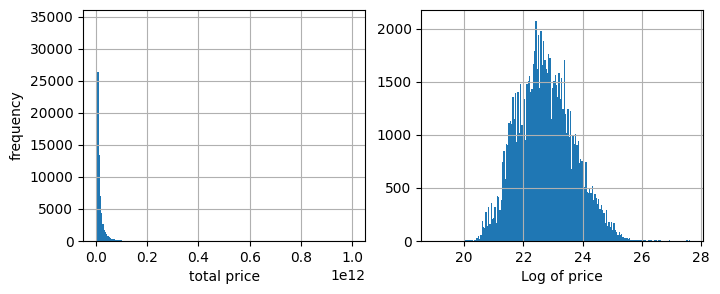

In [95]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=False)
cleaned_df["price"].hist(ax=axs[0], bins=200)
cleaned_df["price"].apply(lambda x: np.log(x)).hist(ax=axs[1], bins=200)
axs[0].set_xlabel("total price")
axs[1].set_xlabel("Log of price")
axs[0].set_ylabel("frequency")
plt.show()

#### meter

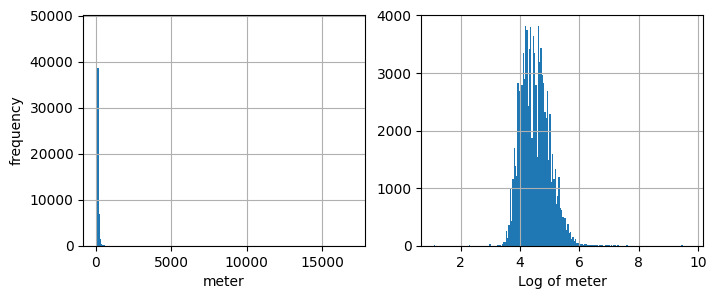

In [96]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=False)
cleaned_df["meter"].hist(ax=axs[0], bins=200)
cleaned_df["meter"].apply(lambda x: np.log(x)).hist(ax=axs[1], bins=200)
axs[0].set_xlabel("meter")
axs[1].set_xlabel("Log of meter")
axs[0].set_ylabel("frequency")
plt.show()

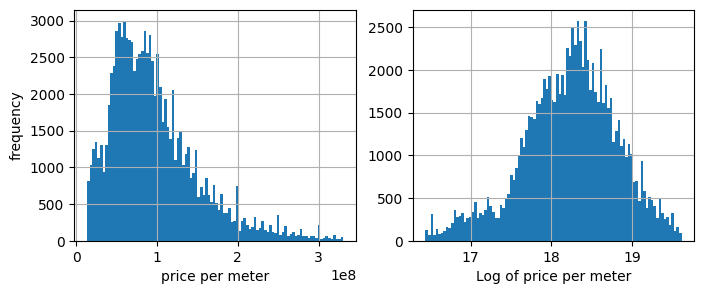

In [97]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=False)
cleaned_df["price_m2"].hist(ax=axs[0], bins=100)
cleaned_df["price_m2"].apply(lambda x: np.log(x)).hist(ax=axs[1], bins=100)
axs[0].set_xlabel("price per meter")
axs[1].set_xlabel("Log of price per meter")
axs[0].set_ylabel("frequency")
plt.show()

#### 

#### Age

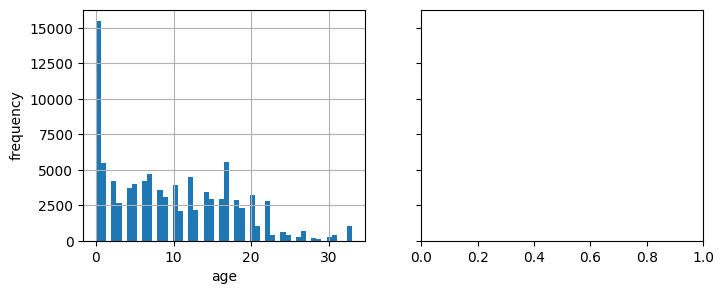

In [98]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
cleaned_df["age"].hist(ax=axs[0], bins=50)
# cleaned_df["age"].apply(lambda x: np.log(x)).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("age")
# axs[1].set_xlabel("Log of age")
axs[0].set_ylabel("frequency")
plt.show()

### preprocessing & pipelines

In [99]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

In [100]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer , make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

#### X, y selection

In [101]:
X = cleaned_df.drop(['price', 'price_m2'], axis=1)
y_price = cleaned_df['price']
y = cleaned_df['price_m2']

In [102]:
num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

In [103]:
cat_pipeline = make_pipeline(
      SimpleImputer(strategy="most_frequent"),
      OneHotEncoder(handle_unknown="ignore"))

In [104]:
log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())

In [105]:
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)

In [106]:
cat_attributes = ['business_type', 'district' , 'elevator', 'parking', 'depot', 'real_state_agent', 'if_near']
ordinal_attributes = ['floor_0', 'rooms']
num_attributes = ['age', 'meter']

preprocessing_1 = ColumnTransformer([
    ('cat', cat_pipeline, cat_attributes),
    ('num', num_pipeline, num_attributes),
    ('ord', num_pipeline, ordinal_attributes)],
     remainder='drop')

In [107]:
cat_attributes_2 = ['business_type', 'district' , 'elevator', 'parking', 'depot', 'real_state_agent','floor_0', 'rooms','if_near']
num_attributes_2= ['age', 'meter']

preprocessing_2 = ColumnTransformer([
    ('cat', cat_pipeline, cat_attributes_2),
    ('num', num_pipeline, num_attributes_2)],
     remainder='drop')

#### train test split

In [108]:
from sklearn.model_selection import train_test_split

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [110]:
XX_train, XX_test, yy_train, yy_test = train_test_split(X, y_price)

#### linear_regression senario-1

In [111]:
from sklearn.linear_model import LinearRegression

In [112]:
lin_reg = make_pipeline(preprocessing_1, LinearRegression())
lin_reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['business_type', 'district',
                                                   'elevator', 'parking',
                                                   'depot', 'real_state_agent',
                                                   'if_near']),
                                                 ('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age', 'meter']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['floor_0', 'rooms'])])),
                ('linearregression', LinearRegression())])

#### evaluation - linear regression

In [113]:
y_predict_lr = lin_reg.predict(X_test)

print('r2 square : ', r2_score(y_test, y_predict_lr))
print('mean squared error : ', mean_squared_error(y_test, y_predict_lr, squared=False))
print('mean absolute error : ', mean_absolute_error(y_test, y_predict_lr))
print('mean absolute percentage error : ', mean_absolute_percentage_error(y_test, y_predict_lr))

r2 square :  0.7834016413650343
mean squared error :  25431157.964549106
mean absolute error :  16680041.937614309
mean absolute percentage error :  0.2319355047788869


In [114]:
lin_reg = make_pipeline(preprocessing_1, LinearRegression())
lin_reg.fit(XX_train, np.log(yy_train))

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['business_type', 'district',
                                                   'elevator', 'parking',
                                                   'depot', 'real_state_agent',
                                                   'if_near']),
                                                 ('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age', 'meter']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['floor_0', 'rooms'])])),
                ('linearregression', LinearRegression())])

In [115]:
yy_predict_lr = np.exp(lin_reg.predict(XX_test))

print('r2 square : ', r2_score(yy_test, yy_predict_lr))
print('mean squared error : ', mean_squared_error(yy_test, yy_predict_lr, squared=False))
print('mean absolute error : ', mean_absolute_error(yy_test, yy_predict_lr))
print('mean absolute percentage error : ', mean_absolute_percentage_error(yy_test, yy_predict_lr))

r2 square :  -42287.91196141994
mean squared error :  3763358716844.1436
mean absolute error :  33691297155.562355
mean absolute percentage error :  0.30655730786379787


#### senario - 2

In [116]:
lin_reg = make_pipeline(preprocessing_2, LinearRegression())
lin_reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['business_type', 'district',
                                                   'elevator', 'parking',
                                                   'depot', 'real_state_agent',
                                                   'floor_0', 'rooms',
                                                   'if_near']),
                                                 ('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age', 'meter'])])),
                ('linearregression', LinearRegression())])

In [117]:
y_predict_lr = lin_reg.predict(X_test)

print('r2 square : ', r2_score(y_test, y_predict_lr))
print('mean squared error : ', mean_squared_error(y_test, y_predict_lr, squared=False))
print('mean absolute error : ', mean_absolute_error(y_test, y_predict_lr))
print('mean absolute percentage error : ', mean_absolute_percentage_error(y_test, y_predict_lr))

r2 square :  0.7900305732356585
mean squared error :  25038977.283176582
mean absolute error :  16299496.172218971
mean absolute percentage error :  0.22539107472427583


In [118]:
lin_reg = make_pipeline(preprocessing_2, LinearRegression())
lin_reg.fit(XX_train, np.log(yy_train))

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['business_type', 'district',
                                                   'elevator', 'parking',
                                                   'depot', 'real_state_agent',
                                                   'floor_0', 'rooms',
                                                   'if_near']),
                                                 ('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age', 'meter'])])),
                ('linearregression', LinearRegression())])

In [119]:
yy_predict_lr = np.exp(lin_reg.predict(XX_test))

print('r2 square : ', r2_score(yy_test, yy_predict_lr))
print('mean squared error : ', mean_squared_error(yy_test, yy_predict_lr, squared=False))
print('mean absolute error : ', mean_absolute_error(yy_test, yy_predict_lr))
print('mean absolute percentage error : ', mean_absolute_percentage_error(yy_test, yy_predict_lr))

r2 square :  -12495.533563495048
mean squared error :  2045771578489.5361
mean absolute error :  20572951542.077213
mean absolute percentage error :  0.2875142791810823


#### xgboost  senario-1

In [120]:
import xgboost as xgb

In [121]:
xg_reg = make_pipeline(preprocessing_1, xgb.XGBRegressor(objective="reg:squarederror"))
xg_reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['business_type', 'district',
                                                   'elevator', 'parking',
                                                   'depot', 'real_state_agent',
                                                   'if_near']),
                                                 ('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

#### evaluatio xgboost senario -1

In [122]:
y_predict_xg = xg_reg.predict(X_test)

print('r2 square : ', r2_score(y_test, y_predict_xg))
print('mean squared error : ', mean_squared_error(y_test, y_predict_xg, squared=False))
print('mean absolute error : ', mean_absolute_error(y_test, y_predict_xg))
print('mean absolute percentage error : ', mean_absolute_percentage_error(y_test, y_predict_xg))

r2 square :  0.810490062983338
mean squared error :  23787814.792202592
mean absolute error :  16289395.587903751
mean absolute percentage error :  0.2278415973738457


In [123]:
xg_reg = make_pipeline(preprocessing_1, xgb.XGBRegressor(objective="reg:squarederror"))
xg_reg.fit(XX_train, np.log(yy_train))

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['business_type', 'district',
                                                   'elevator', 'parking',
                                                   'depot', 'real_state_agent',
                                                   'if_near']),
                                                 ('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [124]:
yy_predict_xg = np.exp(xg_reg.predict(XX_test))

print('r2 square : ', r2_score(yy_test, yy_predict_xg))
print('mean squared error : ', mean_squared_error(yy_test, yy_predict_xg, squared=False))
print('mean absolute error : ', mean_absolute_error(yy_test, yy_predict_xg))
print('mean absolute percentage error : ', mean_absolute_percentage_error(yy_test, yy_predict_xg))

r2 square :  0.6760796076712785
mean squared error :  10415533153.42523
mean absolute error :  2240925821.387837
mean absolute percentage error :  0.20534872128244946


#### xgboost  senario-2

In [125]:
xg_reg = make_pipeline(preprocessing_2, xgb.XGBRegressor(objective="reg:squarederror"))
xg_reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['business_type', 'district',
                                                   'elevator', 'parking',
                                                   'depot', 'real_state_agent',
                                                   'floor_0', 'rooms',
                                                   'if_near']),
                                                 ('num',
                                                  Pipeline(steps=[('simpleimpu...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

#### evaluatio xgboost senario -2

In [126]:
y_predict_xg = xg_reg.predict(X_test)

print('r2 square : ', r2_score(y_test, y_predict_xg))
print('mean squared error : ', mean_squared_error(y_test, y_predict_xg, squared=False))
print('mean absolute error : ', mean_absolute_error(y_test, y_predict_xg))
print('mean absolute percentage error : ', mean_absolute_percentage_error(y_test, y_predict_xg))

r2 square :  0.8070099566255815
mean squared error :  24005237.479529567
mean absolute error :  16391490.528597543
mean absolute percentage error :  0.23152000764000416
